In [2]:
import project_metrics.project_metrics as metrics
import numpy as np
import pandas as pd
import pickle
from os.path import exists

In [3]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score

import scikitplot as skplt
import matplotlib
import matplotlib.pyplot as plt

In [4]:
df_train = pd.read_csv("train.csv")
df_val= pd.read_csv("val.csv")
df_test = pd.read_csv("test.csv")

In [5]:
df_train.drop("INDEX", inplace=True, axis =1)
df_val.drop("INDEX", inplace=True, axis =1)
df_test.drop("INDEX", inplace=True, axis =1)

df_train.drop("Unnamed: 0", inplace=True, axis =1)
df_val.drop("Unnamed: 0", inplace=True, axis =1)
df_test.drop("Unnamed: 0", inplace=True, axis =1)

df_train.drop("IND_BOM_1_2", inplace=True, axis =1)
df_val.drop("IND_BOM_1_2", inplace=True, axis =1)
df_test.drop("IND_BOM_1_2", inplace=True, axis =1)

In [6]:
y_train = df_train["IND_BOM_1_1"].values
y_val = df_val["IND_BOM_1_1"].values
y_test = df_test["IND_BOM_1_1"].values

In [7]:
df_train.drop("IND_BOM_1_1", inplace=True, axis =1)
df_val.drop("IND_BOM_1_1", inplace=True, axis =1)
df_test.drop("IND_BOM_1_1", inplace=True, axis =1)

In [8]:
X_train = df_train.values
X_val = df_val.values
X_test = df_test.values

In [9]:
def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

# Final Project

## Gradient-boosting

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import keras


MODELS_PATH = "Models/GradientBoosting"
HISTORY_PATH = f"{MODELS_PATH}/history"
MODEL_PATH = f"{MODELS_PATH}/model"

In [11]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier

In [12]:
def create_sklearn_compatible_model():
    model = Sequential()
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [18]:
gb_cf = Sequential()

history_file = HISTORY_PATH + "1.npy"
model_file = MODEL_PATH + "1"

gb_cf.add(Dense(16, activation='relu'))
gb_cf.add(Dense(1, activation='sigmoid'))
gb_cf.compile(optimizer='adam', loss='mean_squared_error')

if not exists(history_file) or  not exists(model_file):
    history = gb_cf.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=[EarlyStopping(patience=10,verbose=1)], validation_data=(X_val, y_val))
    np.save(history_file,history.history)
    gb_cf.save(model_file)
else:
    print("Model was already trained")
    
history=np.load(history_file, allow_pickle='TRUE').item()
gb_cf = keras.models.load_model(model_file)

Epoch 1/100
7972/7972 [==============================] - 8s 945us/step - loss: 0.2284 - val_loss: 0.2236
Epoch 2/100
7972/7972 [==============================] - 7s 884us/step - loss: 0.2233 - val_loss: 0.2227
Epoch 3/100
7972/7972 [==============================] - 7s 889us/step - loss: 0.2220 - val_loss: 0.2227
Epoch 4/100
7972/7972 [==============================] - 7s 882us/step - loss: 0.2211 - val_loss: 0.2229
Epoch 5/100
7972/7972 [==============================] - 7s 881us/step - loss: 0.2206 - val_loss: 0.2231
Epoch 6/100
7972/7972 [==============================] - 7s 885us/step - loss: 0.2202 - val_loss: 0.2221
Epoch 7/100
7972/7972 [==============================] - 7s 878us/step - loss: 0.2198 - val_loss: 0.2213
Epoch 8/100
7972/7972 [==============================] - 7s 881us/step - loss: 0.2194 - val_loss: 0.2225
Epoch 9/100
7972/7972 [==============================] - 7s 877us/step - loss: 0.2192 - val_loss: 0.2226
Epoch 10/100
7972/7972 [==============================]

### Experimento Inicial

C:\Users\marco\AppData\Local\Temp\ipykernel_36616\2645845749.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  mlp_clf = KerasClassifier(build_fn=create_sklearn_compatible_model,


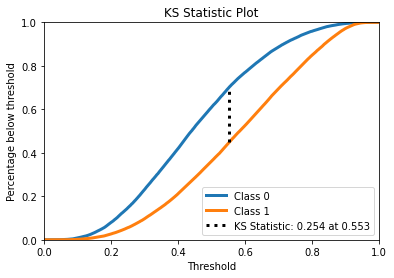

Performance no conjunto de validação:

Accuracy:         0.6240
Recall:           0.6388
Precision:        0.6204
F1:               0.6295
AUROC:            0.6737
AUPR:             0.6703


In [19]:
mlp_clf = KerasClassifier(build_fn=create_sklearn_compatible_model, 
                          batch_size=64, epochs=100,
                          verbose=0)
mlp_clf.fit(X_train, y_train)
mlp_pred_class = mlp_clf.predict(X_val)
mlp_pred_scores = mlp_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, mlp_pred_class, mlp_pred_scores)
print('Performance no conjunto de validação:')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Vamos fazer a testagem agora com todos os parametros do GradientBoostingClassifier no default

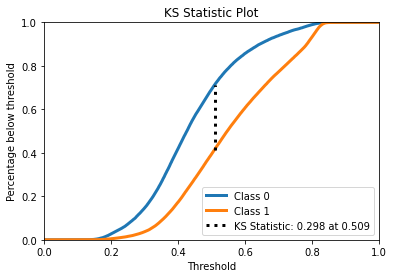


Accuracy:         0.6487
Recall:           0.6065
Precision:        0.6624
F1:               0.6332
AUROC:            0.7056
AUPR:             0.6989


In [20]:
gb_clf = GradientBoostingClassifier()  
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

### Experimento Posteriores

Vamos agora modificar os parametros para conseguirmos diferentes resultados 

In [23]:
gb_clf = GradientBoostingClassifier(n_estimators=500)  
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

TypeError: float() argument must be a string or a number, not 'type'

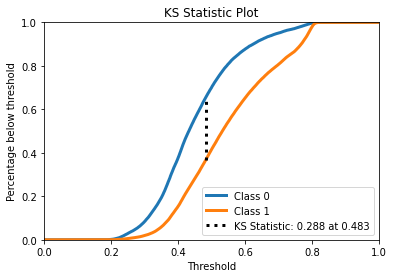


Accuracy:         0.6425
Recall:           0.5851
Precision:        0.6610
F1:               0.6207
AUROC:            0.6989
AUPR:             0.6914


In [21]:
gb_clf = GradientBoostingClassifier(n_estimators=50)  
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

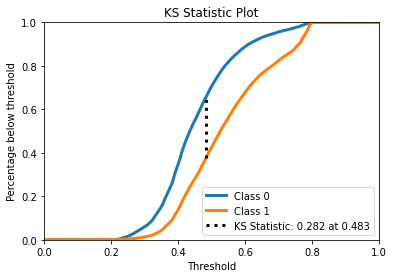


Accuracy:         0.6404
Recall:           0.5757
Precision:        0.6612
F1:               0.6155
AUROC:            0.6950
AUPR:             0.6879


In [28]:
gb_clf = GradientBoostingClassifier(
        n_estimators=500,
        validation_fraction=0.2,
        n_iter_no_change=10,
        tol=0.01,
        random_state=0,)  
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Primeiro testei variando o numero de estimadores pra ver o resultado

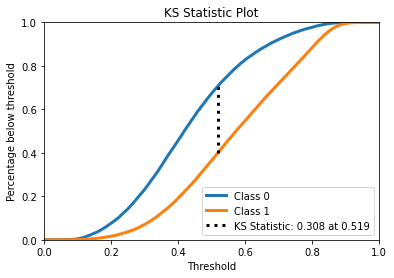


Accuracy:         0.6537
Recall:           0.6349
Precision:        0.6597
F1:               0.6471
AUROC:            0.7115
AUPR:             0.7055


In [17]:
gb_clf = GradientBoostingClassifier(learning_rate=0.5)  
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

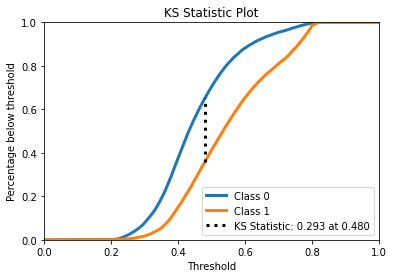


Accuracy:         0.6456
Recall:           0.5878
Precision:        0.6647
F1:               0.6239
AUROC:            0.7032
AUPR:             0.6965


In [18]:
gb_clf = GradientBoostingClassifier(learning_rate=0.05)  
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

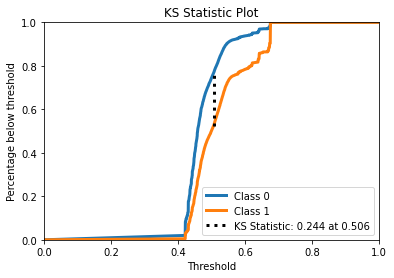


Accuracy:         0.6214
Recall:           0.4981
Precision:        0.6611
F1:               0.5681
AUROC:            0.6720
AUPR:             0.6717


In [19]:
gb_clf = GradientBoostingClassifier(learning_rate=0.01)  
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Depois fiz testes variando o learning_rate

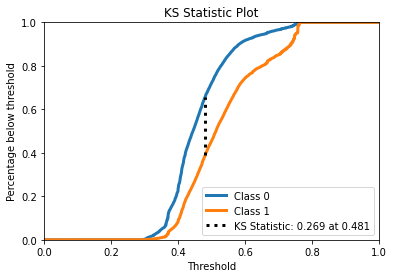


Accuracy:         0.6335
Recall:           0.5466
Precision:        0.6616
F1:               0.5986
AUROC:            0.6868
AUPR:             0.6821


In [29]:
gb_clf = GradientBoostingClassifier(
        n_estimators=1000,
        validation_fraction=0.2,
        n_iter_no_change=5,
        tol=0.01,
        random_state=0,)  
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

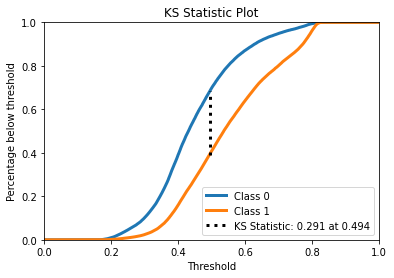


Accuracy:         0.6446
Recall:           0.5927
Precision:        0.6614
F1:               0.6252
AUROC:            0.7004
AUPR:             0.6932


In [30]:
gb_clf = GradientBoostingClassifier(
        n_estimators=1000,
        validation_fraction=0.2,
        n_iter_no_change=20,
        tol=0.01,
        random_state=0,)  
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

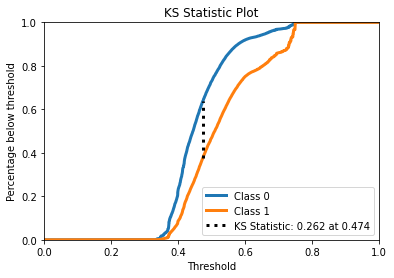


Accuracy:         0.6302
Recall:           0.5321
Precision:        0.6619
F1:               0.5899
AUROC:            0.6830
AUPR:             0.6794


In [31]:
gb_clf = GradientBoostingClassifier(
        n_estimators=1000,
        validation_fraction=0.1,
        n_iter_no_change=5,
        tol=0.01,
        random_state=0,)  
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

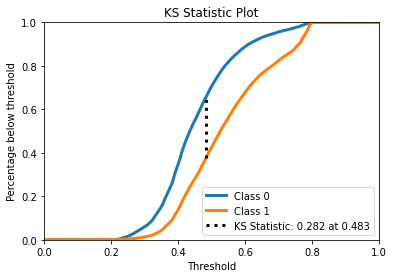


Accuracy:         0.6404
Recall:           0.5757
Precision:        0.6612
F1:               0.6155
AUROC:            0.6950
AUPR:             0.6879


In [32]:
gb_clf = GradientBoostingClassifier(
        n_estimators=1000,
        validation_fraction=0.2,
        n_iter_no_change=10,
        tol=0.01,
        random_state=0,)  
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Por ultimo implementei diferentes early stopping
